# Climatologies of vertical profiles of salinity and temperature from LOCO and CMEMS

In [1]:
import scipy.io as sio
import gsw
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import seaborn as sns
sns.set_style('dark')
import datetime
from datetime import timedelta
from info import datadir, figdir, getMonths

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = sio.loadmat(datadir+'LOCO_CMEMS_val.mat')

time = data['time'][0]
t0 = datetime.datetime(1950,1,1,0,0) # origin of time = 1 January 1950, 00:00:00 UTC
dates = np.array([t0 + datetime.timedelta(hours=i) for i in time])
depth_cmems = data['depth_cmems'][0]
depth_loco = data['depth_loco'][0]

SA_cmems = data['SA_cmems_depth'][:,8:151]
SA_loco = data['SA_loco'][:,8:151]
CT_cmems = data['CT_cmems_depth'][:,8:151]
CT_loco = data['CT_loco'][:,8:151]
sigma0_cmems = gsw.sigma0(SA_cmems,CT_cmems)
sigma0_loco = data['sigma0_loco'][:,8:151]

In [3]:
months = getMonths(dates[8:151])
    
def makeClimatologyCMEMS(data):
    """
    Computes the climatology of a timeseries of depth profiles.
    
    Parameters:
        data (numpy array): contains the timeseries of depth profiles,
                            must have dimensions (time,depth).
    """
    nvert = np.shape(data)[0] # number of vertical levels
    data_clim = np.zeros((12,nvert))
    for i in range(12):
        data_clim[i,:] = np.nanmean([data[:,j] for j in months[i]],axis=0)
    return data_clim

SA_cmems_clim = makeClimatologyCMEMS(SA_cmems)
CT_cmems_clim = makeClimatologyCMEMS(CT_cmems)
sigma0_cmems_clim = makeClimatologyCMEMS(sigma0_cmems)


min_depth_ind_loco = np.where(depth_loco<200)[0][-1]
max_depth_ind_loco = np.where(depth_loco>600)[0][0]

def makeClimatologyLOCO(data):
    nvert = np.shape(data)[0] # number of vertical levels
    data_clim = np.zeros((12,nvert))
    for i in range(12):
        num = []
        for j in months[i]:
            if not np.all(np.isnan(data[min_depth_ind_loco:max_depth_ind_loco+1,j])):
                num.append(j)
        data_clim[i,:] = np.nanmean([data[:,k] for k in num],axis=0)
    return data_clim    


SA_loco_clim = makeClimatologyLOCO(SA_loco)
CT_loco_clim = makeClimatologyLOCO(CT_loco)
sigma0_loco_clim = makeClimatologyLOCO(sigma0_loco)

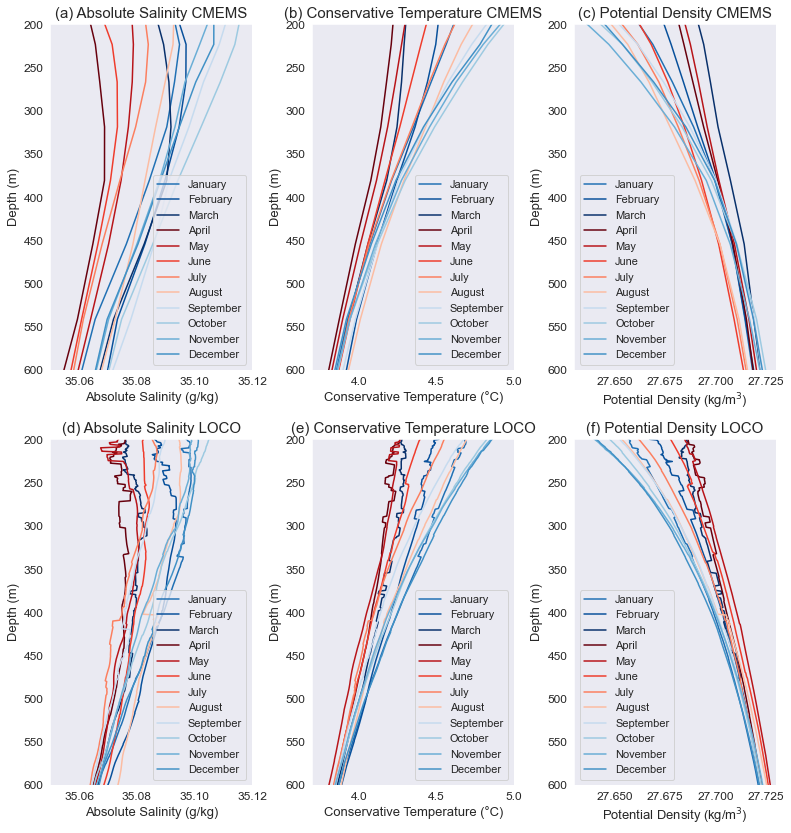

In [6]:
month_labels = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August',\
          8: 'September', 9: 'October', 10: 'November', 11: 'December'}
cmap1 = matplotlib.cm.get_cmap('Blues') # for winter months
colors1 = np.array([cmap1(i) for i in np.linspace(0.25,1,7)])
cmap2 = matplotlib.cm.get_cmap('Reds_r') # for summer months
colors2 = np.array([cmap2(i) for i in np.linspace(0,0.75,5)])
colors = np.vstack((colors1,colors2))

def plotClimatology(ax,data,vert,maxvert,title,datalabel,vertlabel='Depth (m)'):
    for i in range(12):
        ax.plot(data[i,0:maxvert],vert[0:maxvert],label=month_labels[i],color=colors[(i+4)%12])
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', labelsize=12)
    ax.set_xlabel(datalabel, fontsize=13)
    ax.set_ylabel(vertlabel, fontsize=13)
    ax.set_title(title, fontsize=15)
    ax.legend(fontsize=11)

max_depth_ind_cmems = np.where(depth_cmems>500)[0][0]
max_depth_ind_loco = np.where(depth_loco>600)[0][0]
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(13,14))
plotClimatology(ax1,SA_cmems_clim,depth_cmems,max_depth_ind_cmems+2,'(a) Absolute Salinity CMEMS','Absolute Salinity (g/kg)')
plotClimatology(ax2,CT_cmems_clim,depth_cmems,max_depth_ind_cmems+2,'(b) Conservative Temperature CMEMS','Conservative Temperature ('+'\u00B0'+'C)')
plotClimatology(ax3,sigma0_cmems_clim,depth_cmems,max_depth_ind_cmems+2,'(c) Potential Density CMEMS','Potential Density (kg/m$^3$)')
plotClimatology(ax4,SA_loco_clim,depth_loco,max_depth_ind_loco+1,'(d) Absolute Salinity LOCO','Absolute Salinity (g/kg)')
plotClimatology(ax5,CT_loco_clim,depth_loco,max_depth_ind_loco+1,'(e) Conservative Temperature LOCO','Conservative Temperature ('+'\u00B0'+'C)')
plotClimatology(ax6,sigma0_loco_clim,depth_loco,max_depth_ind_loco+1,'(f) Potential Density LOCO','Potential Density (kg/m$^3$)')

ax1.set_xlim(35.05,35.12)
ax4.set_xlim(35.05,35.12)
ax2.set_xlim(3.7,5)
ax5.set_xlim(3.7,5)
ax3.set_xlim(27.63,27.73)
ax6.set_xlim(27.63,27.73)

t = depth_loco[min_depth_ind_loco]
b = 600
ax1.set_ylim(top=t,bottom=b)
ax2.set_ylim(top=t,bottom=b)
ax3.set_ylim(top=t,bottom=b)
ax4.set_ylim(top=t,bottom=b)
ax5.set_ylim(top=t,bottom=b)
ax6.set_ylim(top=t,bottom=b)
plt.subplots_adjust(wspace=0.3)

plt.savefig(figdir+'LOCO_CMEMS_val_clim.png',bbox_inches='tight')
plt.show()